# Neural Network Training Example

---

In this notebook, I want to show you how to convert historical crypto tick data into a datastream, suitable for training a neural network, which will predict the future direction of the price movement.

The process is done step-by-step with explanations at every step. You can start and run the notebook in Google Colab, where it takes around 20-25 minute to run completely. Of course, you can also execute it step-by-step.

The accoring Git Repo can be found under: [The link to the repo](https://github.com/girsigit/CryptoCrystalBall)

In [ ]:
# Check if the notebook is run in google colab, if so, import some stuff
import sys
import os

colab = 'google.colab' in sys.modules

if colab:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    %cd /content/CryptoCrystalBall/JupyterDocker/notebooks

Running in Colab
Cloning into 'CryptoCrystalBall'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 282 (delta 113), reused 241 (delta 76), pack-reused 0
Receiving objects: 100% (282/282), 15.72 MiB | 17.57 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/CryptoCrystalBall/JupyterDocker/notebooks


In [ ]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [ ]:
# Get the current directory
current_dir = os.getcwd()
current_dir_splitted = current_dir.split(os.sep)
current_dir_splitted

['', 'content', 'CryptoCrystalBall', 'JupyterDocker', 'notebooks']

In [ ]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'DataStreamCreator')
print(f"dsc_dir: {dsc_dir}")

ind_dir = os.path.join(os.sep, *current_dir_splitted[:-2], 'IndicatorCalculator')
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [ ]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [ ]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/CryptoCrystalBall/DemoData


In [ ]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted[:-2], 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/CryptoCrystalBall/Documentation/Images


In [ ]:
# Define a global random seed
RANDOM_SEED = 11

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [ ]:
# Define the paths to two example tick (OHLCV) files. There are only two files
# to keep the example tidy
# This step would be done by scanning a directory in a real application
EXAMPLE_FILE_PATHS = [os.path.join(DATA_PATH, "BTC-USDT.csv"), os.path.join(DATA_PATH, "ETH-USDT.csv")]
EXAMPLE_FILE_PATHS

['/content/CryptoCrystalBall/DemoData/BTC-USDT.csv',
 '/content/CryptoCrystalBall/DemoData/ETH-USDT.csv']

In [ ]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 512

In [ ]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 256

In [ ]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 6
MIDSPAN = 48
LONGSPAN = 120

---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

It is important to mention that the last timestamp of an X-Block (a frame from the past) matches the timestamp of the y-data entry (lookout into the future of the price).

<br>

As a target value (y data type), the future direction and its derviation of the price have been chosen, as they are easy to visualize and understand.




In [ ]:
# Import the required TensorFlow modules
# Todo: Remove unused ones

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D, UnitNormalization
from keras.layers import Conv1D, Conv2D
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
# Set direction and derivation information as y target
# Both y values (direction & derivation) are in the interval [-1.0,1.0]

Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_TYPE_DICT

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0}

In [ ]:
# For training, use the first example file 'BTC-USDT.csv'.
# The FileListToDataStream generator requires a list, even if its only one file.

TRAIN_FILES = [(EXAMPLE_FILE_PATHS[0])]
TRAIN_FILES

['/content/CryptoCrystalBall/DemoData/BTC-USDT.csv']

---
# Get the feature dimension of the dataset for creating the NN

This is required for setting up the neural network. Maybe this could be done at runtime, but is not necessary, as the indicator configuration, which leads to the feature dimension, has to be the same in the predication phase afterwards and therefore has to be known.

In [ ]:
# Initialize the FileListToDataStream generator
dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                     batch_size = BATCH_SIZE,
                                                     X_Block_lenght = X_BLOCK_LENGHT,
                                                     y_type_dict=Y_TYPE_DICT
                                                    )
# Get the first batch
batch = next(dataStreamTraining)
XShape = batch['X'].shape
yShape = batch['y'].shape
FEATURES = XShape[-1]

print(f"Shape of X-Block array: (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES) -> {XShape}")
print(f"Shape of y-data array: (BATCH_SIZE, DIRECTION & DERVIATION) -> {yShape}")
print(f"FEATURES: {FEATURES}")

INFO:root:File 'BTC-USDT.csv' loaded, 0 left


Shape of X-Block array: (BATCH_SIZE, X_BLOCK_LENGHT, FEATURES) -> (256, 512, 226)
Shape of y-data array: (BATCH_SIZE, DIRECTION & DERVIATION) -> (256, 2)
FEATURES: 226


---
# Create the actual data stream for training

Re-Create the data stream used for finding the feature count to start from a fresh generator.

Please note that the `shuffle` flag is set to `true` here. This provides shuffing of both the input file list (irrelevant in this example) and position where the `X-Blocks` and `y-data` informations are collected.

<br>

## Attention, weird behavior!
A python generator function has to be applied on the dataStream, as the return provided by `FileListToDataStream` method is not a 'real' generator and therefore cannot be used by TF.
```
Todo: Bugfix --> Include this into the FileListToDataStream
```

In [ ]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True
                                                      )
  
  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']
      _y = ne['y']
      
      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorTraining, 
                                               output_types = (tf.float32, tf.float32), # Todo: Automatically determine data type from dataStreamTraining (float, int for categories)
                                               output_shapes=((XShape), (yShape))
                                               )
tfGenTraining.prefetch(buffer_size=2)
tfGenTraining

<FlatMapDataset element_spec=(TensorSpec(shape=(256, 512, 226), dtype=tf.float32, name=None), TensorSpec(shape=(256, 2), dtype=tf.float32, name=None))>

---
# Create the neural network

In the example, two Conv1D pyramids are used to extract features at different levels out of the feature and the time dimension.

It is also possible to use different architecures, like LSTM, Conv2D, Attention-Based ones or even NLP-based models. I have tried many different ones and will publish them into the model zoo.

```
Todo: Create Model Zoo
```

In [ ]:
# Create the example model

def CreateModelExample():
  # Define model parameters
  CNN_INITIAL_FILTERS_FEATURES = 256
  CNN_NUMBER_FILTERS_FEATURES = 4

  CNN_INITIAL_FILTERS_TIME = 64
  CNN_NUMBER_FILTERS_TIME = 3
  
  CNN_KERNEL_SIZE = 11

  DENSE_SIZE_REGRESSOR = 32
  
  # Create the model input  
  inputTicksAndIndicators = Input(shape=(X_BLOCK_LENGHT, FEATURES), name='inputTicksAndIndicators', dtype='float32')

  # Normalize the input data, as it has a wide value spread (range of 1e8)
  normalized = UnitNormalization(name="UnitNormalizationInput", axis=-2)(inputTicksAndIndicators)

  # ----------------------------------------------------------------------------

  # As an example a 1D-CNN pyramid is used to extract higher-level features out
  # of the indicator+tick dimension
  feature_conv_layers = []

  for i in range(CNN_NUMBER_FILTERS_FEATURES):
    if 0 == i:
      source_layer = normalized
    else:
      source_layer = feature_conv
    
    feature_conv = Conv1D(filters=int(CNN_INITIAL_FILTERS_FEATURES/(2**i)), 
                          kernel_size=CNN_KERNEL_SIZE, 
                          strides=1, 
                          padding="same",
                          name=f"Feature_Conv1D_{i}")(source_layer)

    feature_conv = MaxPooling1D(pool_size=2,
                                padding="same",
                                data_format="channels_first",
                                name=f"Feature_MaxPooling1D_{i}")(feature_conv)

    feature_conv_layers.append(feature_conv)

  # Concaternate all extracted filters of the indicator+tick dimension together
  indicator_filters = Concatenate(name="Feature_Filters_Concatenate")(feature_conv_layers)

  # ----------------------------------------------------------------------------

  # A pyramid is also applied on the time dimension
  time_conv_layers = []

  for i in range(CNN_NUMBER_FILTERS_TIME):
    if 0 == i:
      # Flip the order of time and feature dimension to apply the Conv1D on time
      source_layer = Permute((2,1), name="Permute_Time_Features")(indicator_filters)
    else:
      source_layer = time_conv
    
    time_conv = Conv1D(filters=int(CNN_INITIAL_FILTERS_TIME/(2**i)), 
                       kernel_size=CNN_KERNEL_SIZE, 
                       strides=1, 
                       padding="same",
                       name=f"Time_Conv1D_{i}")(source_layer)

    time_conv = MaxPooling1D(pool_size=2,
                             padding="same",
                             data_format="channels_first",
                             name=f"Time_MaxPooling1D_{i}")(time_conv)

    time_conv_layers.append(time_conv)

  # Concaternate all extracted filters of the time dimension together
  time_filters = Concatenate(name="Time_Filters_Concatenate")(time_conv_layers)

  # ----------------------------------------------------------------------------

  # Regressor - Dense layers to calculate the direction and its derivation
  regr = Flatten(name="Regressor_Flatten")(time_filters)
  regr = Dense(DENSE_SIZE_REGRESSOR, name="Regressor_Dense_1", activation='tanh')(regr)
  regr = Dense(DENSE_SIZE_REGRESSOR, name="Regressor_Dense_2", activation='relu')(regr)

  # ----------------------------------------------------------------------------

  # The output are two values (direction and derivation) in the range [-1.0, 1.0]
  output = Dense(2, activation='tanh', name="Output")(regr)
  outputs = [output]

  # Combine it all into a model object
  model = Model(inputs=inputTicksAndIndicators, outputs=outputs, name='ModelExample')

  return model

model = CreateModelExample()
model.summary(line_length=220)

Model: "ModelExample"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                           Output Shape                                     Param #                   Connected to                                                             
 inputTicksAndIndicators (InputLayer)                                   [(None, 512, 226)]                               0                         []                                                                       
                                                                                                                                                                                                                            
 UnitNormalizationInput (UnitNormalization)                             (None, 512, 226)      

In [ ]:
# Create an optimizer

optimizer = Adam(
    learning_rate=1e-04,
    epsilon=1e-05,
    decay=0.01)

In [ ]:
# Compile the model
# To predict the float values of direction and derivation, the 'Mean Squared Error' loss is used
# In addition, the 'Mean Average Error' is calculated

model.compile(
    optimizer = optimizer,
    loss = ['mse'], 
    metrics=['mae'])

In [ ]:
# Load the TensorBoard notebook extension for visualization

%load_ext tensorboard

log_dir = "/content/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=1
    )

---
# Train the network

**Hint:** There is a warning that there were not enough files (only 1) to provide 4 parallel generators, falling back to 1 generators. This is ok, as for this example only one training file is provided. In a real application, there would be more files.

The training for 5 epochs takes about 12 minutes on a colab GPU. The epoch count can be increased to provide 'deeper' learning, while in this example this would not lead to better results, as the network would overfit on the 'BTC-USDT' price and would not be able to predict other currencies.

In a real application, the tuning of these hyperparameters would be crucial.

In [ ]:
# Train the model

model.fit(tfGenTraining, 
          epochs=5, 
          verbose=1, 
          callbacks=[tensorboard_callback]
          )

Epoch 1/5


INFO:root:File 'BTC-USDT.csv' loaded, 0 left


    190/Unknown - 136s 653ms/step - loss: 0.0674 - mae: 0.1644

190/190 [==============================] - 137s 658ms/step - loss: 0.0674 - mae: 0.1644
Epoch 2/5


INFO:root:File 'BTC-USDT.csv' loaded, 0 left


190/190 [==============================] - 124s 642ms/step - loss: 0.0538 - mae: 0.1444
Epoch 3/5


INFO:root:File 'BTC-USDT.csv' loaded, 0 left


190/190 [==============================] - 126s 650ms/step - loss: 0.0505 - mae: 0.1398
Epoch 4/5


INFO:root:File 'BTC-USDT.csv' loaded, 0 left


190/190 [==============================] - 126s 655ms/step - loss: 0.0485 - mae: 0.1372
Epoch 5/5


INFO:root:File 'BTC-USDT.csv' loaded, 0 left


190/190 [==============================] - 127s 655ms/step - loss: 0.0470 - mae: 0.1352


In [ ]:
# Calculate the metrics after training on the train dataset

metrics_train = model.evaluate(tfGenTraining)
mse_train, mae_train = metrics_train
print("\n")
print(f"MSE Training: {mse_train}")
print(f"MAE Training: {mae_train}")

INFO:root:File 'BTC-USDT.csv' loaded, 0 left


    190/Unknown - 107s 549ms/step - loss: 0.0447 - mae: 0.1324

190/190 [==============================] - 107s 551ms/step - loss: 0.0447 - mae: 0.1324


MSE Training: 0.04468248412013054
MAE Training: 0.13235564529895782


In [ ]:
# Show the metrics in TensorBoard
# Hint: If it says 'no data' just switch the categories in the top bar, then it refreshes and works
%tensorboard --logdir /content/logs

---
# Try to Re-Predict the values

Use the trained network to re-predict the direction and derivation values of the train dataset. For the visualization, the `shuffle` flag has to be set to `False`.

**Important: A batch size of 1 is used to avoid loss of data.**
The FileListToDataStream generator would stop if there is less data than the batch size, so the last few values would not been predicted.

In [ ]:
# A python generator function has to be applied on the dataStream
# Todo: Include this into the FileListToDataStream
def pythonGeneratorEval():
  # Initialize the FileListToDataStream generator
  dataStreamEval = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = 1,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False # For visualization
                                                      )
  while True:  
    try:
      ne = next(dataStreamEval)
      _X = ne['X']
      _y = ne['y']
      
      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [ ]:
# Create a Tensorflow dataset, which can be fed to the network
# Batch size is set to 1

tfGenEval = tf.data.Dataset.from_generator(pythonGeneratorEval, 
                                               output_types = (tf.float32, tf.float32), # Todo: Automatically from dataStreamTraining
                                               output_shapes=((1, XShape[1], XShape[2]), (1, yShape[1]))
                                               )
tfGenEval

<FlatMapDataset element_spec=(TensorSpec(shape=(1, 512, 226), dtype=tf.float32, name=None), TensorSpec(shape=(1, 2), dtype=tf.float32, name=None))>

In [ ]:
# Predict the values
p = model.predict(tfGenEval)
p.shape

INFO:root:File 'BTC-USDT.csv' loaded, 0 left


  48885/Unknown - 252s 5ms/step

48891/48891 [==============================] - 252s 5ms/step


(48891, 2)

In [ ]:
# Get the real y values (-> Ground Truth) out of the tfGenEval generator for plotting and comparison

# Create numpy generator
it = tfGenEval.as_numpy_iterator()

# Init the values
yReal = None
i = 0

# Get the data
while True:
  try:
    X,y = next(it)

    if yReal is None:
      yReal = y
    else:
      yReal = np.concatenate([yReal, y])

    i += 1
    if i % 1000 == 0:
      print(i)

  except StopIteration:
    break

print(yReal.shape)

INFO:root:File 'BTC-USDT.csv' loaded, 0 left


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000


(48891, 2)


In [ ]:
# Split the predicted data into two values for easier processing
p_dir = p[:,0]
p_dir_derivation = p[:,1]

In [ ]:
# Also split the real y values
real_y_dir = yReal[:,0]
real_y_dir_derivation = yReal[:,1]

Text(0, 0.5, 'Direction')

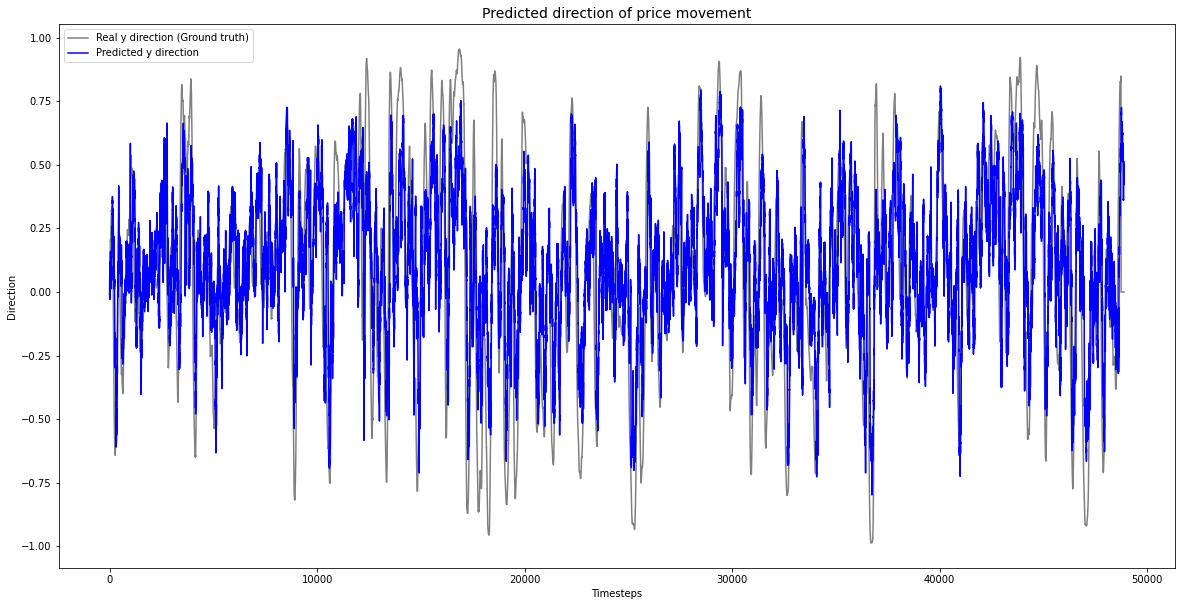

In [ ]:
# Plot the prediction and the ground truth
chart_name="Predicted direction of price movement"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(real_y_dir, color="gray", label="Real y direction (Ground truth)")
_ = ax1.plot(p_dir, color="blue", label="Predicted y direction")

_= plt.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
# Plot the direction info over the price

In [ ]:
# Load the according tick data
tickdata = pd.read_csv(EXAMPLE_FILE_PATHS[0])
tickdata.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdata.sort_index()

tickdata

,open,high,low,close,volume,quoteVolume
startsAt,,,,,,
1449928800,420.000000,420.000000,420.000000,420.000000,0.000304,0.127596
1449932400,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449936000,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449939600,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
1449943200,420.000000,420.000000,420.000000,420.000000,0.000000,0.000000
...,...,...,...,...,...,...
1627761600,41312.243514,41819.689357,41174.024002,41504.090831,6.954679,288855.157694
1627765200,41532.010689,41974.904927,41532.010689,41960.070000,7.271290,303437.038256
1627768800,41961.294435,41977.030664,41645.385796,41870.548474,6.137356,256691.373423


## **Hint:** Prediction size mismatch

The predicted array is shorter than the tick table in the time dimension, namely by the value of `X_BLOCK_LENGHT`. This is because the first complete X-Block can be generated at table index 127 (-> 128 elements), therefore the generation process starts there.

To match the ticks in the table for plotting or mapping the predictions, the first `X_BLOCK_LENGHT` rows of `tickData` have to be dropped.

In [ ]:
print(f"Shape of the predicted values: {p.shape}")
print(f"Shape of the loaded tick table: {tickdata.shape}")

print(f"\nDifference in the time dimension: {tickdata.shape[0] - p.shape[0]}")
print(f"X_BLOCK_LENGHT: {X_BLOCK_LENGHT}")

Shape of the predicted values: (48891, 2)
Shape of the loaded tick table: (49403, 6)

Difference in the time dimension: 512
X_BLOCK_LENGHT: 512


In [ ]:
# Crop the beginning of the tick table
tickDataResized = tickdata.iloc[X_BLOCK_LENGHT:,]
tickDataResized.shape

(48891, 6)

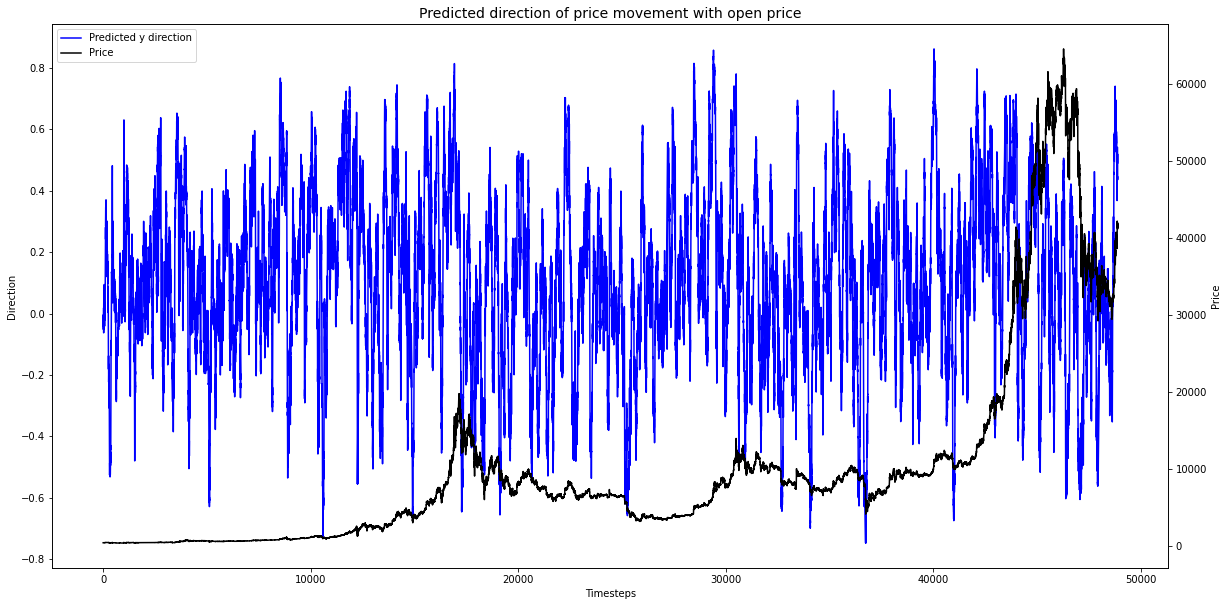

In [ ]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_dir, color="blue", label="Predicted y direction")

ax2 = ax1.twinx()

ax2.plot(tickDataResized.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

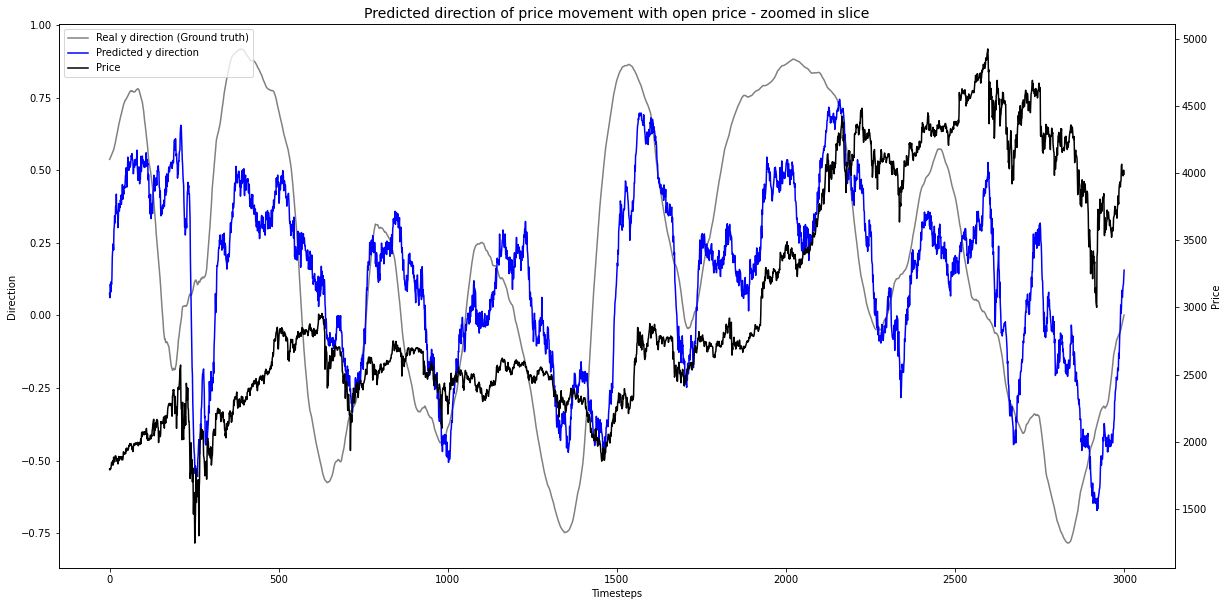

In [ ]:
# Plot the prediction once again over the open price, now only a slice
SLICE_START_INDEX = 12000
SLICE_END_INDEX = 15000

chart_name="Predicted direction of price movement with open price - zoomed in slice"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(real_y_dir[SLICE_START_INDEX:SLICE_END_INDEX], color="gray", label="Real y direction (Ground truth)")
_ = ax1.plot(p_dir[SLICE_START_INDEX:SLICE_END_INDEX], color="blue", label="Predicted y direction")

ax2 = ax1.twinx()

ax2.plot(tickDataResized.loc[:,'open'].values[SLICE_START_INDEX:SLICE_END_INDEX], color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

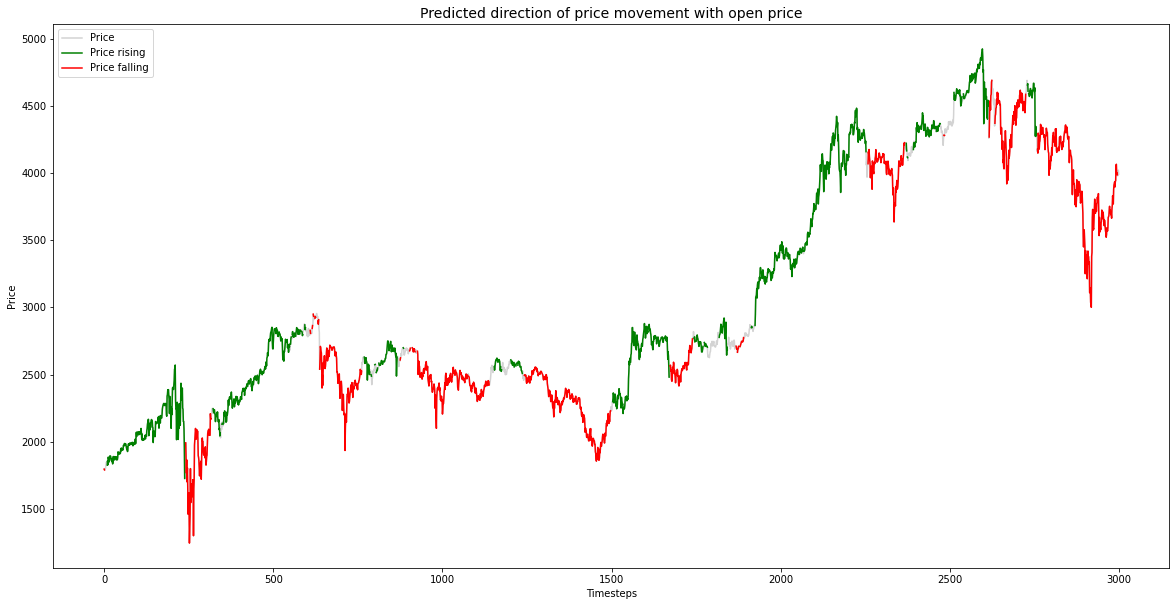

In [ ]:
# Plot a colored price line depending on the predicted direction
SLICE_START_INDEX = 12000
SLICE_END_INDEX = 15000

chart_name="Predicted direction of price movement with open price"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

# _ = ax1.plot(p_test_dir)

priceValues = tickDataResized.loc[:,'open'].values[SLICE_START_INDEX:SLICE_END_INDEX]

# Select the rising price values
priceValuesRising = copy.deepcopy(priceValues)
priceValuesRising[p_dir[SLICE_START_INDEX:SLICE_END_INDEX] < 0.2] = np.nan

# Select the falling price values
priceValuesFalling = copy.deepcopy(priceValues)
priceValuesFalling[p_dir[SLICE_START_INDEX:SLICE_END_INDEX] > 0.1] = np.nan

ax1.plot(priceValues, color="lightgray", label="Price")
ax1.plot(priceValuesRising, color="green", label="Price rising")
ax1.plot(priceValuesFalling, color="red", label="Price falling")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Price")

# Show a legend
plt.legend(loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
# Predict an unknown currency

The next step is to use the network to predict a currency it has never seen before, in the case of this example, ETH-USDT.

In [ ]:
# For testing, use the second example file 'ETH-USDT.csv'. The FileListToDataStream generator requires a list, even if its only one file
TEST_FILES = [(EXAMPLE_FILE_PATHS[1])]
TEST_FILES

['/content/CryptoCrystalBall/DemoData/ETH-USDT.csv']

In [ ]:
# A python generator function has to be applied on the dataStream
def pythonGeneratorTest():
  # Initialize the FileListToDataStream generator
  dataStreamTest = DataStreamCreator.FileListToDataStream(fileList = TEST_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=False # For visualization
                                                      )
  while True:  
    try:
      ne = next(dataStreamTest)
      _X = ne['X']
      _y = ne['y']
      
      yield (_X, _y)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [ ]:
# Create a Tensorflow dataset, which can be fed to the network
tfGenTest = tf.data.Dataset.from_generator(pythonGeneratorTest, 
                                               output_types = (tf.float32, tf.float32), # Todo: Automatically from dataStreamTraining
                                               output_shapes=((XShape), (yShape))
                                               )
tfGenTest

<FlatMapDataset element_spec=(TensorSpec(shape=(256, 512, 226), dtype=tf.float32, name=None), TensorSpec(shape=(256, 2), dtype=tf.float32, name=None))>

In [ ]:
# Calculate the networks metrics on the test dataset
# For a comparsion, also the metric results from the evaluation on the train
# set are printed.

metrics_test = model.evaluate(tfGenTest)
mse_test, mae_test = metrics_test
print(f"MSE Test: {mse_test} - for comparison, MSE Training: {mse_train}")
print(f"MAE Test: {mae_test} - for comparison, MAE Training: {mae_train}")

INFO:root:File 'ETH-USDT.csv' loaded, 0 left


    144/Unknown - 73s 498ms/step - loss: 0.0723 - mae: 0.1719

144/144 [==============================] - 74s 499ms/step - loss: 0.0723 - mae: 0.1719
MSE Test: 0.07233753800392151 - for comparison, MSE Training: 0.04468248412013054
MAE Test: 0.1719352751970291 - for comparison, MAE Training: 0.13235564529895782


---
# Visualize the predictions

Other to the previous visualization, instead of a batch size of 1 the normal size is used to speed up the process. Doing this, some data in the end of the table is ignored, but that makes no difference here, as it is just for visualization.

In [ ]:
# Predict the direction and derivation - on colab, this takes around 3 1/2 minutes
pTest = model.predict(tfGenTest)
pTest.shape

In [ ]:
# Get the real y values (-> Ground Truth) out of the tfGenTest generator for plotting and comparison

# Create numpy generator
it = tfGenTest.as_numpy_iterator()

# Init the values
yRealTest = None
i = 0

# Get the data
while True:
  try:
    X,y = next(it)

    if yRealTest is None:
      yRealTest = y
    else:
      yRealTest = np.concatenate([yRealTest, y])

    i += 1
    if i % 1000 == 0:
      print(i)

  except StopIteration:
    break

print(yRealTest.shape)

In [ ]:
# Split the predicted data into two values for easier processing
p_test_dir = pTest[:,0]
p_test_dir_derivation = pTest[:,1]

In [ ]:
# Also split the real y values
test_real_y_dir = yRealTest[:,0]
test_real_y_dir_derivation = yRealTest[:,1]

In [ ]:
# Plot the prediction and the ground truth
chart_name="Predicted direction of price movement - unknown currency"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(test_real_y_dir, color="gray", label="Real y direction (Ground truth)")
_ = ax1.plot(p_test_dir, color="blue", label="Predicted y direction")

_= plt.legend(loc="upper left")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

In [ ]:
# Load and crop the according tick data
tickdataTest = pd.read_csv(TEST_FILES[0])
tickdataTest.set_index("startsAt", inplace = True) # Todo: Take care of the index name
tickdataTest.sort_index()

tickDataTestResized = tickdataTest.iloc[X_BLOCK_LENGHT:,]
tickDataTestResized

In [ ]:
# Plot the prediction again, now over the open price
chart_name="Predicted direction of price movement with open price - unknown currency"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

_ = ax1.plot(p_test_dir, color="blue", label="Predicted y direction")

ax2 = ax1.twinx()

ax2.plot(tickDataTestResized.loc[:,'open'].values, color="black", label="Price")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Direction")
ax2.set_ylabel("Price")

# Show a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

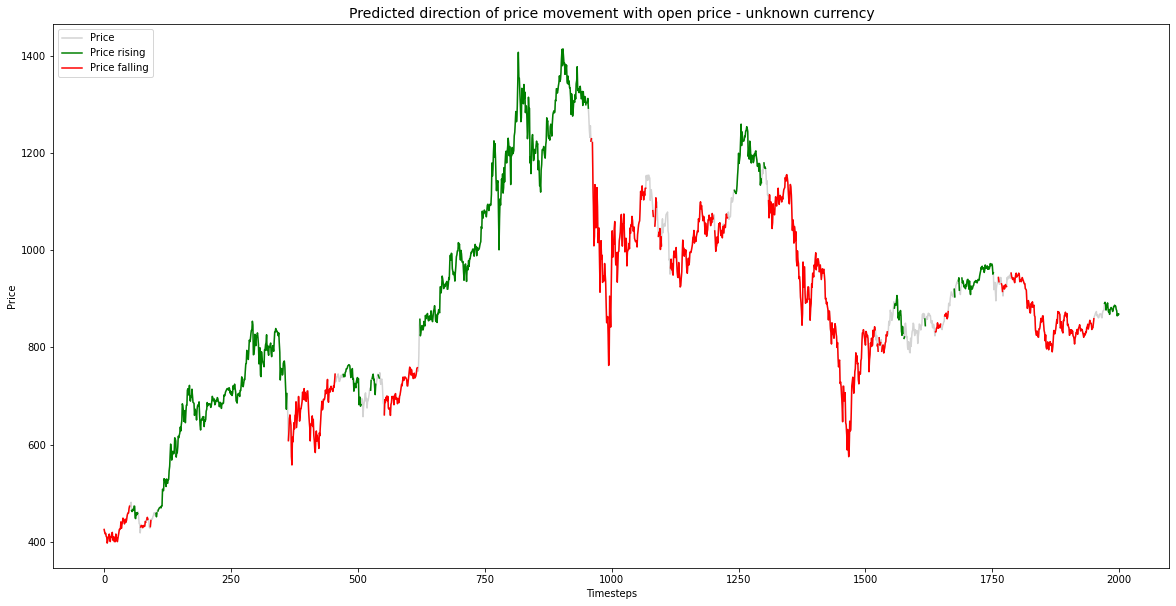

In [53]:
# Plot a colored price line slice depending on the predicted direction
SLICE_START_INDEX = 5000
SLICE_END_INDEX = 7000

chart_name="Predicted direction of price movement with open price - unknown currency"
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title(chart_name, fontsize=14)

priceValues = tickDataTestResized.loc[:,'open'].values[SLICE_START_INDEX:SLICE_END_INDEX]

# Select the rising price values
priceValuesRising = copy.deepcopy(priceValues)
priceValuesRising[p_test_dir[SLICE_START_INDEX:SLICE_END_INDEX] < 0.2] = np.nan

# Select the falling price values
priceValuesFalling = copy.deepcopy(priceValues)
priceValuesFalling[p_test_dir[SLICE_START_INDEX:SLICE_END_INDEX] > 0.1] = np.nan

ax1.plot(priceValues, color="lightgray", label="Price")
ax1.plot(priceValuesRising, color="green", label="Price rising")
ax1.plot(priceValuesFalling, color="red", label="Price falling")

ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Price")

# Show a legend
plt.legend(loc="upper left")

# Save the figure
# fig_name = "FileListToDataStreamExample_" + chart_name.replace(" ", "_").replace("'", "").replace("(", "").replace(")", "") + ".svg"
# plt.savefig(os.path.join(IMG_SAVE_PATH, fig_name), bbox_inches="tight")

---
# Conclusion

Although this is a very simplified example, as a shallow network is trained on a single tick file, the predicted results on a currency the network never seen before are pretty satisfying.

The next steps to take are:
- Provide more data for training, for example my crypto train dataset providing hourly data from my Google Bucket: [Link to Train-Set](https://console.cloud.google.com/storage/browser/cryptocrystalball_public/CryptoDataset/Hourly/Train)
- Evaluate the training progress on a independent data set, not the train set itself. For example, use the crypto eval dataset from my Google Bucket: [Link to Eval-Set](https://console.cloud.google.com/storage/browser/cryptocrystalball_public/CryptoDataset/Hourly/Eval)
- Use an independent test set for checking prediction results, to calculate trade signals and test the trading strategy. Once again, take a look at the test set on my Google Bucket: [Link to Test-Set](https://console.cloud.google.com/storage/browser/cryptocrystalball_public/CryptoDataset/Hourly/Test) <bR> *Todo for me: Add a link to the trade stategy tester*
- Create a more sophisticated neural network -> For example using different Frequency/Time scales (see [Link](https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57) and [Link](https://arxiv.org/pdf/1603.06995.pdf)), use LSTM layers, add Attention routes to the model or even treat the X-Blocks as a sentence and apply NLP networks. For NLP, there will come some code on the Git Repo.
- Create trade signals out of the direction/derivation information.
- Create and test a trading strategy
- Convert it into a live system and earn (or loose, your risk!!) money! :D



